In [4]:
pip install keras-tuner

In [5]:
pip install --upgrade keras-tuner

#Importing libraries

In [6]:
#Importing the necessary libraries -
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import TomekLinks, NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from keras_tuner import Hyperband
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel
from sklearn.model_selection import KFold


#Loading the dataset

In [7]:
# Load the dataset
NewDataPath = '/content/drive/MyDrive/Project 2/AmanAnalysis_Preprocessed_elderlydata (1).csv'
OurElderlyData = pd.read_csv(NewDataPath)

# Displaying the first few rows of the dataset to understand its structure
OurElderlyData.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_range
0,Female,80.0,0,1,never,25.19,6.6,140,0,"[75, 81)"
1,Male,76.0,1,1,current,20.14,4.8,155,0,"[75, 81)"
2,Female,79.0,0,0,No Info,23.86,5.7,85,0,"[75, 81)"
3,Female,78.0,0,0,former,36.05,5.0,130,0,"[75, 81)"
4,Female,67.0,0,0,never,25.69,5.8,200,0,"[61, 68)"
5,Female,76.0,0,0,No Info,27.32,5.0,160,0,"[75, 81)"
6,Male,78.0,0,0,No Info,27.32,6.6,126,0,"[75, 81)"
7,Female,69.0,0,0,never,21.24,4.8,85,0,"[68, 75)"
8,Female,72.0,0,1,former,27.94,6.5,130,0,"[68, 75)"
9,Male,67.0,0,1,not current,27.32,6.5,200,1,"[61, 68)"


#Feature engineering phase ( checking correlation)

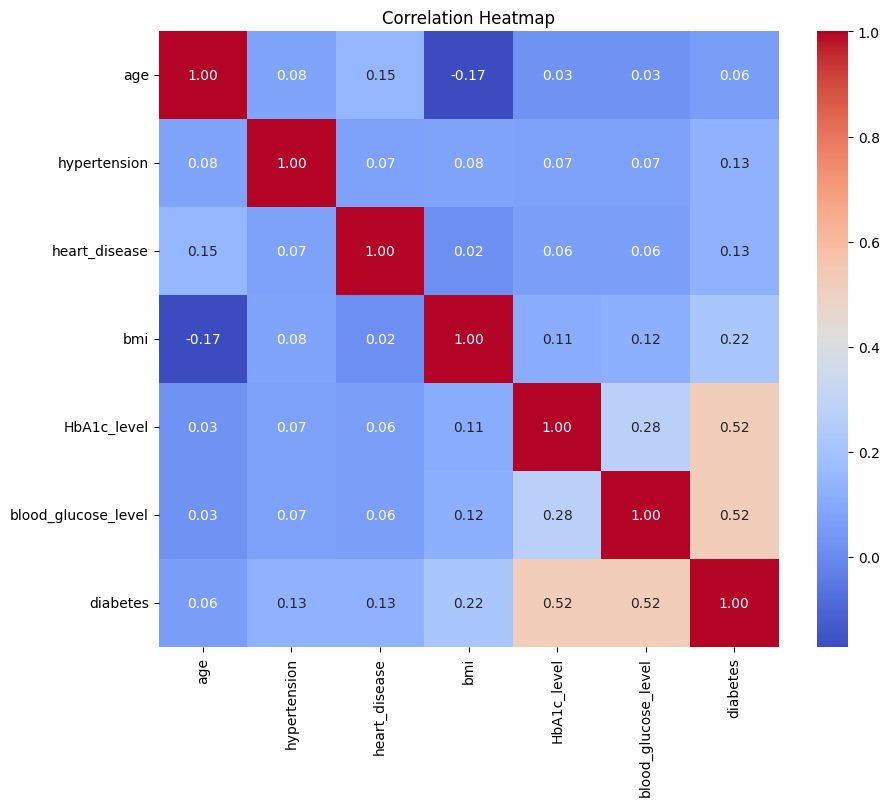

In [8]:
# Calculate the correlation matrix for numeric columns only
numeric_data = OurElderlyData.select_dtypes(include=[np.number])  # This selects only numeric columns
corr = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



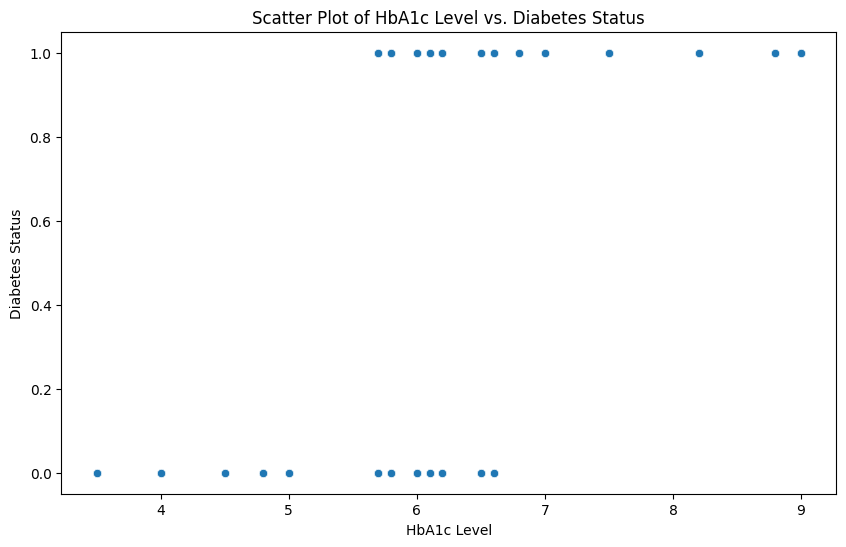

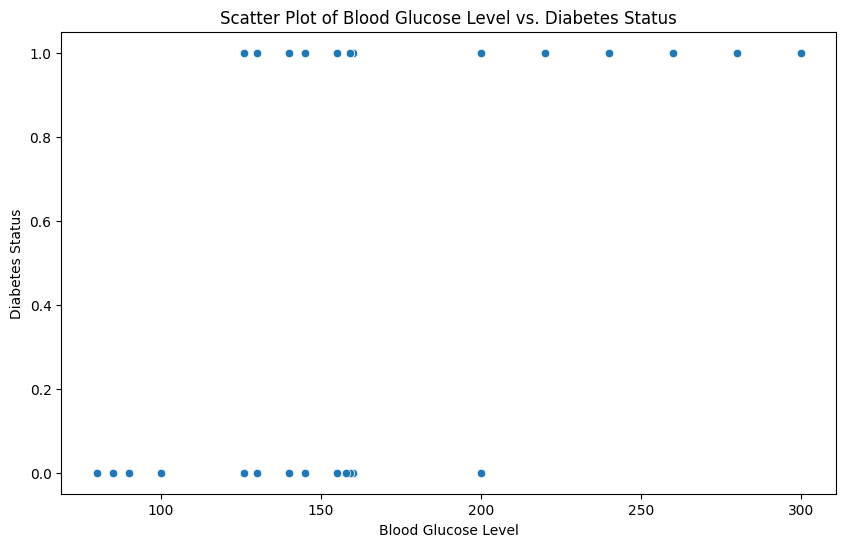

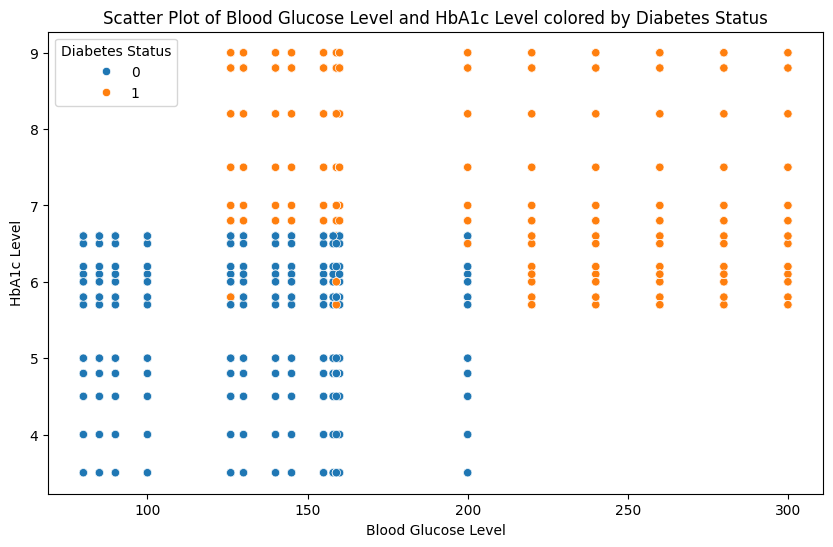

In [9]:
# Scatterplot for HbA1c_level vs. Diabetes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='HbA1c_level', y='diabetes', data=OurElderlyData)
plt.title('Scatter Plot of HbA1c Level vs. Diabetes Status')
plt.xlabel('HbA1c Level')
plt.ylabel('Diabetes Status')
plt.show()

# Scatterplot for blood_glucose_level vs. Diabetes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='blood_glucose_level', y='diabetes', data=OurElderlyData)
plt.title('Scatter Plot of Blood Glucose Level vs. Diabetes Status')
plt.xlabel('Blood Glucose Level')
plt.ylabel('Diabetes Status')
plt.show()

# For a more granular look, we can add a 'hue' to differentiate the points based on another variable, such as hypertension
plt.figure(figsize=(10, 6))
sns.scatterplot(x='blood_glucose_level', y='HbA1c_level', hue='diabetes', data=OurElderlyData)
plt.title('Scatter Plot of Blood Glucose Level and HbA1c Level colored by Diabetes Status')
plt.xlabel('Blood Glucose Level')
plt.ylabel('HbA1c Level')
plt.legend(title='Diabetes Status')
plt.show()

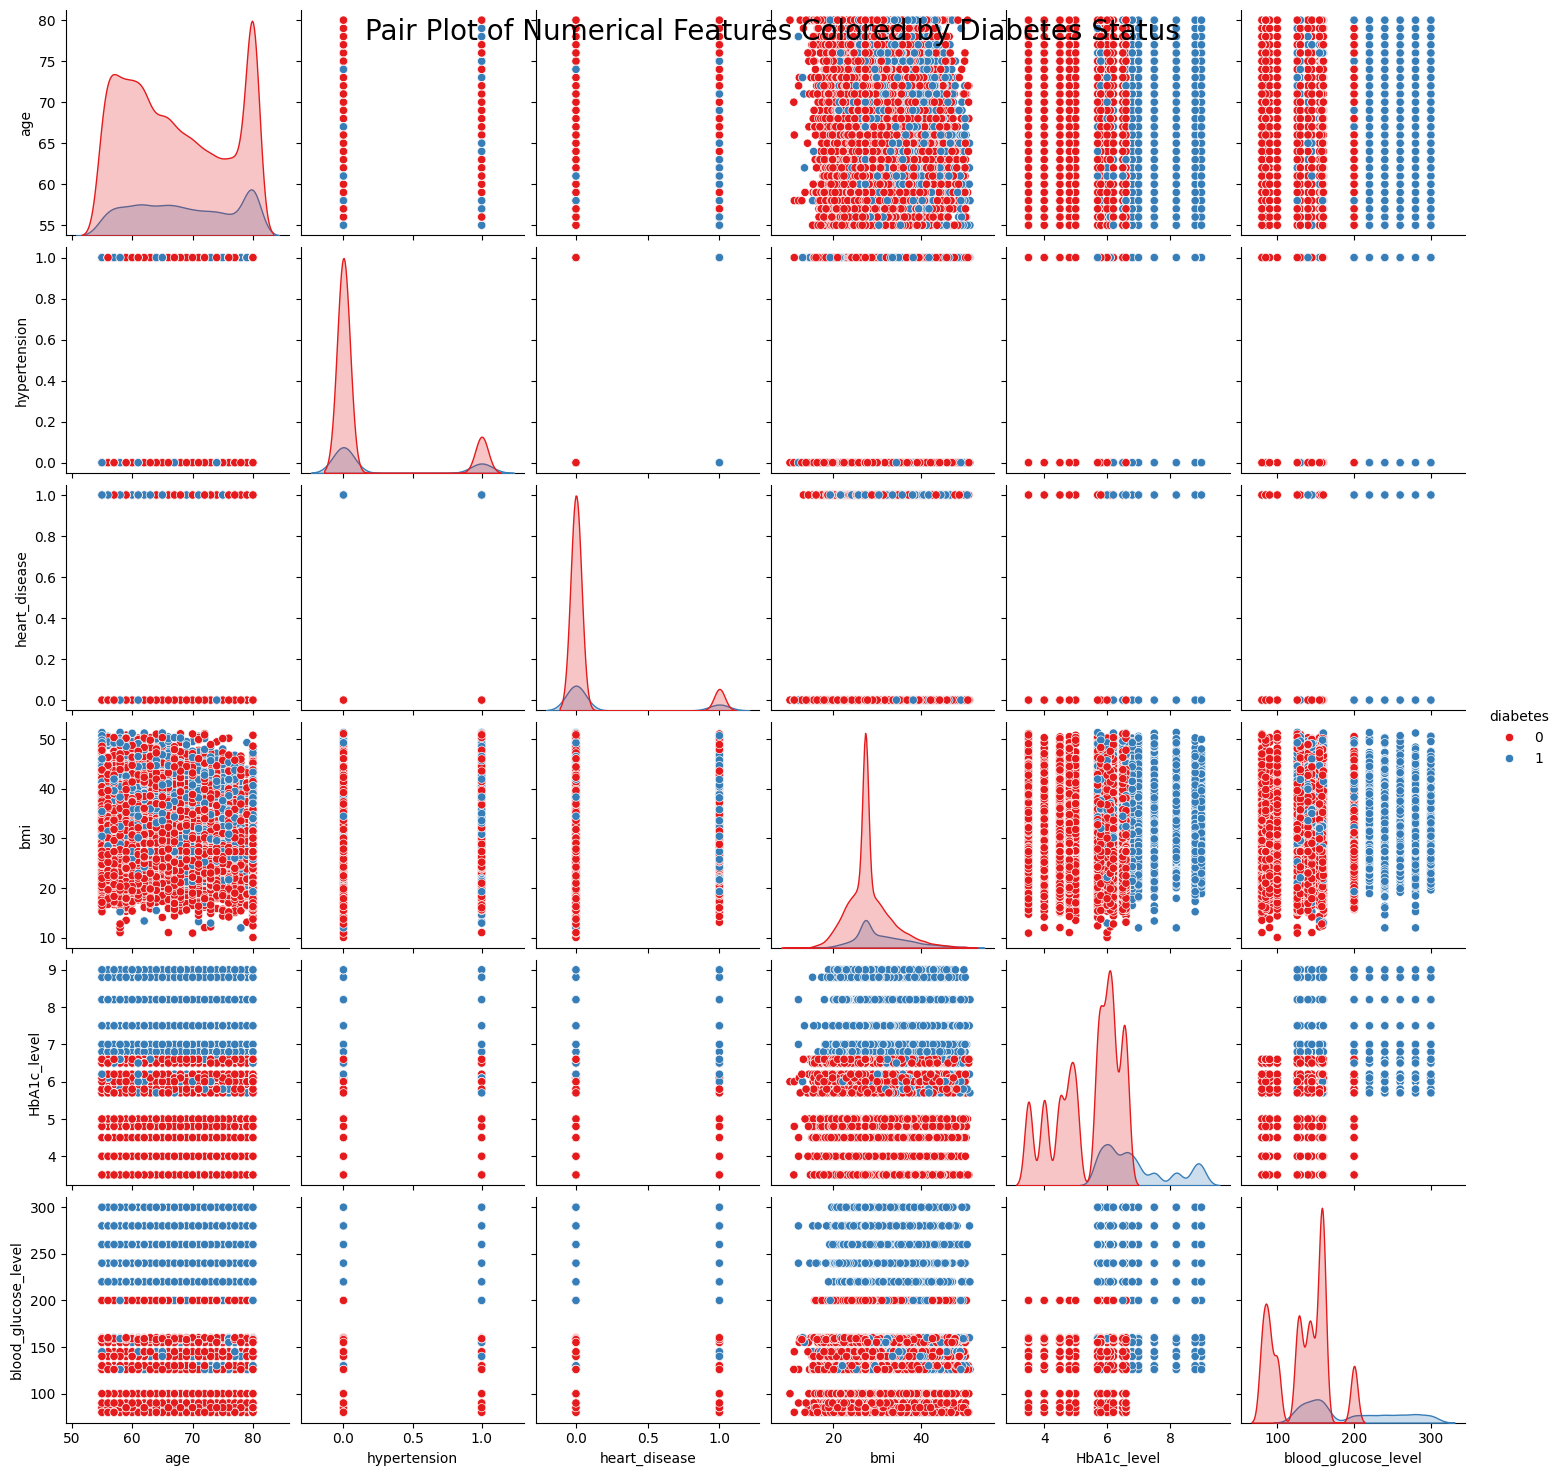

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for the pair plot
numerical_data = OurElderlyData.select_dtypes(include=['float64', 'int64'])

# Create pair plot
sns.pairplot(numerical_data, hue='diabetes', palette='Set1')
plt.suptitle('Pair Plot of Numerical Features Colored by Diabetes Status', size=20)
plt.show()


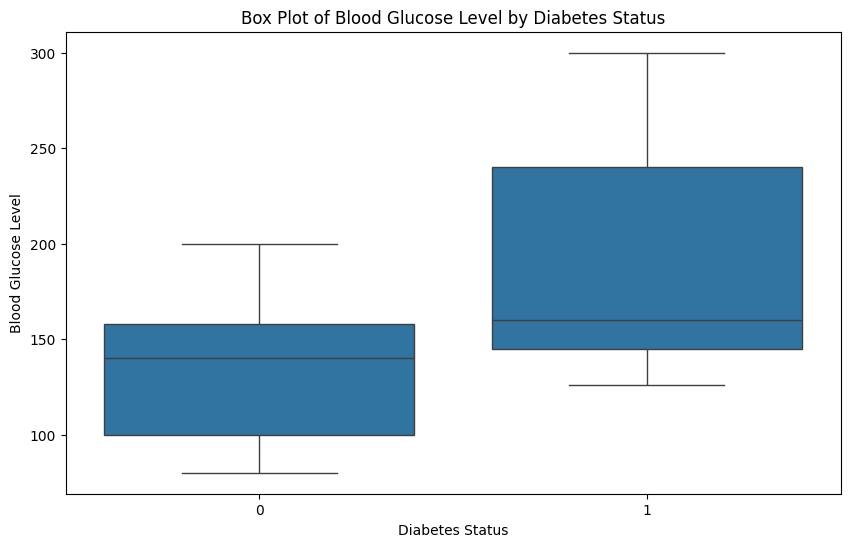

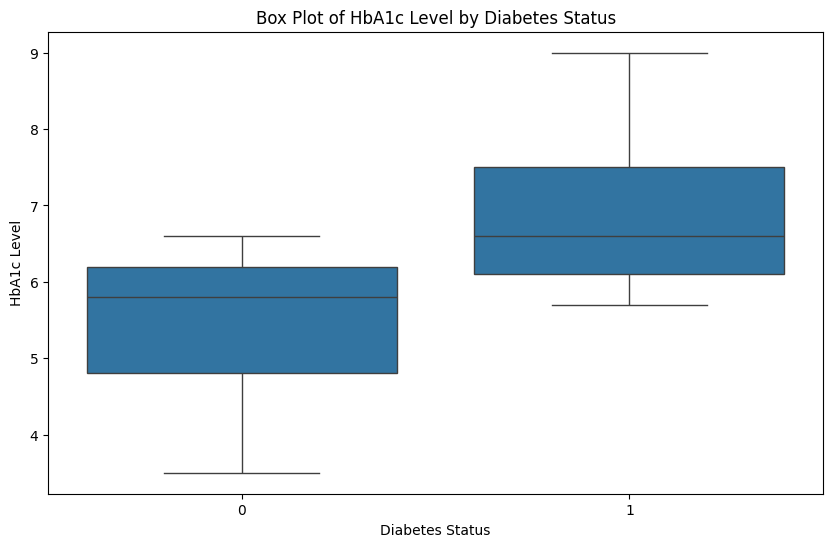

In [11]:
# Boxplot for Blood Glucose Level by Diabetes Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=OurElderlyData)
plt.title('Box Plot of Blood Glucose Level by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Blood Glucose Level')
plt.show()

# Boxplot for HbA1c Level by Diabetes Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='HbA1c_level', data=OurElderlyData)
plt.title('Box Plot of HbA1c Level by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('HbA1c Level')
plt.show()

# Correlated features are used to develop new feature (cluster analysis)

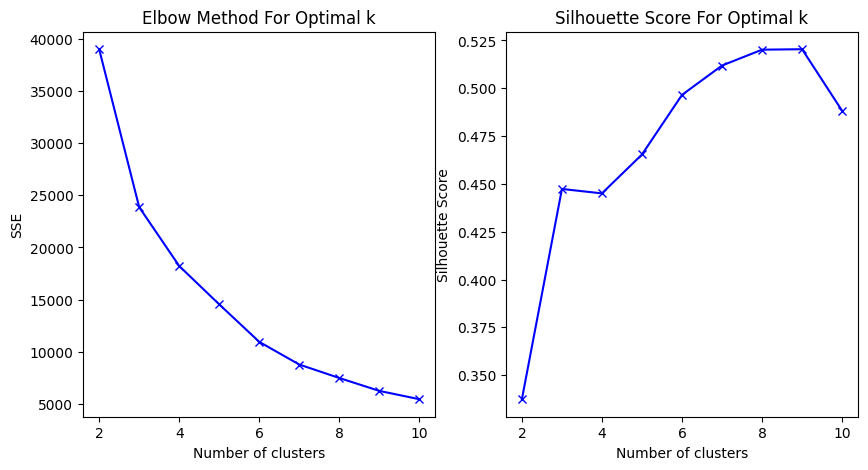

In [12]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(OurElderlyData[['HbA1c_level', 'blood_glucose_level']])

# Calculating the sum of squared distances and silhouette scores for different k values
sse = []
silhouette_scores = []
K_range = range(2, 11)  # Examining 2 to 10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plotting the Elbow Method results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')

# Plotting the Silhouette Score results
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()



# Cluster analysis result are used to perform K-mean clustering to develop new feature

In [13]:
# Assuming 'hba1c' and 'blood_glucose_level' are the columns you want to cluster on
scaler = StandardScaler()
scaled_features = scaler.fit_transform(OurElderlyData[['HbA1c_level', 'blood_glucose_level']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
OurElderlyData['cluster'] = kmeans.fit_predict(scaled_features)

# Check the new dataframe with the cluster labels
print(OurElderlyData.head(30))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


    gender   age  hypertension  heart_disease smoking_history    bmi  \
0   Female  80.0             0              1           never  25.19   
1     Male  76.0             1              1         current  20.14   
2   Female  79.0             0              0         No Info  23.86   
3   Female  78.0             0              0          former  36.05   
4   Female  67.0             0              0           never  25.69   
5   Female  76.0             0              0         No Info  27.32   
6     Male  78.0             0              0         No Info  27.32   
7   Female  69.0             0              0           never  21.24   
8   Female  72.0             0              1          former  27.94   
9     Male  67.0             0              1     not current  27.32   
10  Female  76.0             0              0           never  23.55   
11    Male  73.0             0              0          former  25.91   
12  Female  77.0             1              1           never  3

# Encoding and balncing of target label(undersampling)

In [14]:
# Define target variable and features
X = OurElderlyData.drop(columns=['diabetes'])
y = OurElderlyData['diabetes']  # Assuming the target variable is 'diabetes'

# Identifying numerical and categorical columns
numerical_cols = ['bmi', 'HbA1c_level', 'blood_glucose_level', 'cluster']  # Added cluster to numerical cols
categorical_cols = ['gender', 'smoking_history', 'age_range']

# Creating the full preprocessor
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Applying the preprocessor
X_prepared = full_preprocessor.fit_transform(X)

# Concatenate column names for numerical and generated ones for categorical
cat_feature_names = full_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
column_names = numerical_cols + list(cat_feature_names)
OurElderlyDataTransformed = pd.DataFrame(X_prepared, columns=column_names)

# Balancing the dataset using Tomek links
tomek_links = TomekLinks()
X_resampled, y_resampled = tomek_links.fit_resample(OurElderlyDataTransformed, y)

# Further balancing using NearMiss-2
near_miss = NearMiss(version=2)
X_resampled, y_resampled = near_miss.fit_resample(X_resampled, y_resampled)

# Checking the balance of the target variable after balancing
target_balance_after_balancing = y_resampled.value_counts()
print("After balancing:")
print(target_balance_after_balancing)




After balancing:
diabetes
0    5878
1    5878
Name: count, dtype: int64


# Scaling of dataset

In [15]:
# Convert the resampled X and y arrays back to a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=OurElderlyDataTransformed.columns)

# Create a new DataFrame with resampled data
AmanElderlyData_resampled = X_resampled_df.copy()

# Rename the new DataFrame
AmanElderlyData_resampled.rename(columns={'diabetes': 'diabetes_resampled'}, inplace=True)

# Display the first few rows of the resampled DataFrame
print(AmanElderlyData_resampled.head())

        bmi  HbA1c_level  blood_glucose_level   cluster  gender_Female  \
0  0.743741     0.783466             1.184717  2.010627            0.0   
1  0.934591     0.783466             1.184717  2.010627            0.0   
2  0.525097     0.783466             1.184717  2.010627            1.0   
3  0.799329     0.783466             1.184717  2.010627            0.0   
4  0.536215     0.697383             1.184717  2.010627            1.0   

   gender_Male  smoking_history_No Info  smoking_history_current  \
0          1.0                      0.0                      0.0   
1          1.0                      0.0                      0.0   
2          0.0                      0.0                      0.0   
3          1.0                      0.0                      0.0   
4          0.0                      0.0                      0.0   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                   0.0                     0.0                    1.0  

#Splitting of dataset for train, test

In [16]:
# Splitting the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_df, y_resampled, test_size=0.2, random_state=42)

# Displaying the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (9404, 16)
Shape of X_test: (2352, 16)
Shape of y_train: (9404,)
Shape of y_test: (2352,)


#Checking with random forest

In [17]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the testing data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision on the testing data
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall on the testing data
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1-score on the testing data
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calculate confusion matrix on the testing data
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



Accuracy: 0.9068877551020408
Precision: 0.9367552703941339
Recall: 0.8720136518771331
F1-score: 0.9032258064516129
Confusion Matrix:
[[1111   69]
 [ 150 1022]]


# Tuning of random forest

In [18]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search using GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Initialize the Random Forest classifier with the best parameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)

# Train the classifier on the training data
best_rf_classifier.fit(X_train, y_train)

# Predictions on the testing data
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy on the testing data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.9139726492246089
Accuracy: 0.9115646258503401


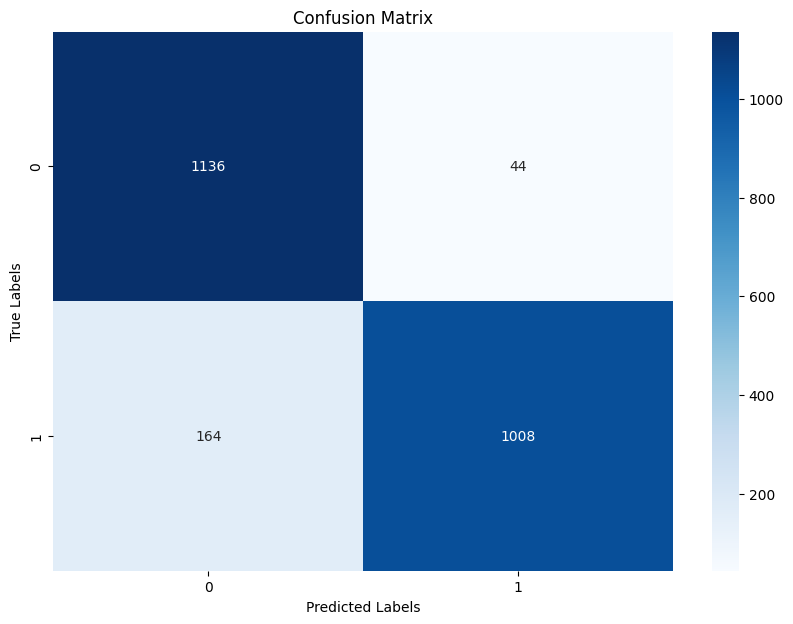

In [19]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Cecking for best parameters for multple machine learning algorithms

In [21]:
# Hyperparameter grids
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
dec_tree_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
naive_bayes_params = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
grad_boost_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}

# Create instances of the classifiers
log_reg = LogisticRegression()
svc = SVC()
dec_tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
grad_boost = GradientBoostingClassifier()

# List of classifiers and their parameter grids
classifiers = [log_reg, svc, dec_tree, naive_bayes, grad_boost]
classifier_names = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Naive Bayes', 'Gradient Boosting']
params = [log_reg_params, svc_params, dec_tree_params, naive_bayes_params, grad_boost_params]

# Perform Grid Search
for clf, name, param in zip(classifiers, classifier_names, params):
    grid_search = GridSearchCV(estimator=clf, param_grid=param, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters for {name}: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.2f}")
    print("\n")



Best Parameters for Logistic Regression: {'C': 0.01, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.78


Best Parameters for Support Vector Machine: {'C': 10, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.90


Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
Best Cross-Validation Score: 0.90


Best Parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best Cross-Validation Score: 0.81


Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 100}
Best Cross-Validation Score: 0.91




# Using best parameter into machine learning algorithm & checking performance

In [22]:
# Reinitialize classifiers with best parameters
log_reg_opt = LogisticRegression(C=0.01, solver='lbfgs', random_state=42)
svc_opt = SVC(C=10, kernel='rbf', random_state=42)
dec_tree_opt = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42)
naive_bayes_opt = GaussianNB(var_smoothing=1e-09)
grad_boost_opt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42)

# List of optimized classifiers
optimized_classifiers = [log_reg_opt, svc_opt, dec_tree_opt, naive_bayes_opt, grad_boost_opt]
classifier_names = ['Optimized Logistic Regression', 'Optimized Support Vector Machine', 'Optimized Decision Tree', 'Optimized Naive Bayes', 'Optimized Gradient Boosting']

# Train and evaluate each optimized classifier
for clf, name in zip(optimized_classifiers, classifier_names):
    clf.fit(X_train, y_train)  # Train
    y_pred = clf.predict(X_test)  # Predict

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")


Results for Optimized Logistic Regression:
Accuracy: 0.78
Precision: 0.80
Recall: 0.76
F1-score: 0.78
Confusion Matrix:
[[954 226]
 [286 886]]


Results for Optimized Support Vector Machine:
Accuracy: 0.90
Precision: 0.97
Recall: 0.82
F1-score: 0.89
Confusion Matrix:
[[1148   32]
 [ 209  963]]


Results for Optimized Decision Tree:
Accuracy: 0.90
Precision: 0.98
Recall: 0.82
F1-score: 0.89
Confusion Matrix:
[[1157   23]
 [ 210  962]]


Results for Optimized Naive Bayes:
Accuracy: 0.81
Precision: 0.84
Recall: 0.75
F1-score: 0.79
Confusion Matrix:
[[1011  169]
 [ 289  883]]


Results for Optimized Gradient Boosting:
Accuracy: 0.91
Precision: 0.97
Recall: 0.84
F1-score: 0.90
Confusion Matrix:
[[1151   29]
 [ 190  982]]




# Machine learning algorithm performance presented in table (Rankwise)

In [23]:
# Reinitialize classifiers with best parameters and their names
classifiers = [
    LogisticRegression(C=0.01, solver='lbfgs', random_state=42),
    SVC(C=10, kernel='rbf', random_state=42),
    DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42),
    GaussianNB(var_smoothing=1e-09),
    GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42),
    RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=42)
]
classifier_names = [
    'Optimized Logistic Regression',
    'Optimized Support Vector Machine',
    'Optimized Decision Tree',
    'Optimized Naive Bayes',
    'Optimized Gradient Boosting',
    'Optimized Random Forest'
]

# Initialize list to hold metrics
results = []

# Train and evaluate each optimized classifier
for clf, name in zip(classifiers, classifier_names):
    clf.fit(X_train, y_train)  # Train
    y_pred = clf.predict(X_test)  # Predict

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in a dictionary and add to list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Sort the DataFrame by F1-score in descending order and add a Rank column
sorted_results_df = results_df.sort_values(by='F1-score', ascending=False).reset_index(drop=True)
sorted_results_df.index = range(1, len(sorted_results_df) + 1)  # Adjusted index so that it start from 1 for ranking
sorted_results_df.index.name = 'Rank'

# Print the sorted DataFrame with rank
print(sorted_results_df)



                                 Model  Accuracy  Precision    Recall  \
Rank                                                                    
1              Optimized Random Forest  0.911565   0.958175  0.860068   
2          Optimized Gradient Boosting  0.906888   0.971316  0.837884   
3              Optimized Decision Tree  0.900935   0.976650  0.820819   
4     Optimized Support Vector Machine  0.897534   0.967839  0.821672   
5                Optimized Naive Bayes  0.805272   0.839354  0.753413   
6        Optimized Logistic Regression  0.782313   0.796763  0.755973   

      F1-score  
Rank            
1     0.906475  
2     0.899679  
3     0.891980  
4     0.888786  
5     0.794065  
6     0.775832  


#Use of keras tuner to find best parameters for neural network.

In [24]:
class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            input_dim=self.input_dim,
            kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-1, sampling='log'))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            kernel_regularizer=l2(hp.Float('l2_second', min_value=1e-5, max_value=1e-1, sampling='log'))
        ))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# Create an instance of the hypermodel
hypermodel = MyHyperModel(input_dim=X_train.shape[1])

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='keras_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.1)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)


Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.8873538970947266

Best val_accuracy So Far: 0.8958554863929749
Total elapsed time: 00h 03m 20s
Best hyperparameters:
units: 288
l2: 0.00019636129765327303
dropout_1: 0.1
l2_second: 2.774974320650127e-05
dropout_2: 0.30000000000000004
learning_rate: 0.00434328104379656
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
74/74 [==============================] - 0s 1ms/step
Accuracy: 0.8860544217687075

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      1180
           1       0.95      0.82      0.88      1172

    accuracy                           0.89      2352
   macro avg       0.89      0.89      0.89      2352
weighted avg       0.89      0.89      0.89      2352



# Use of best parameters into neural network

In [25]:
# Best hyperparameters from the tuning session
best_units = 288
best_l2 = 0.00019636129765327303
best_dropout_1 = 0.1
best_l2_second = 2.774974320650127e-05
best_dropout_2 = 0.30000000000000004
best_learning_rate = 0.00434328104379656

# Create the neural network model using the best hyperparameters
model = Sequential([
    Dense(best_units, input_dim=X_train.shape[1], kernel_regularizer=l2(best_l2)),
    BatchNormalization(),
    Dropout(best_dropout_1),
    Dense(best_units, kernel_regularizer=l2(best_l2_second)),
    LeakyReLU(alpha=0.1),
    Dropout(best_dropout_2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with the optimized learning rate
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the previously split data
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)


Epoch 1/10
847/847 [==============================] - 5s 4ms/step - loss: 0.5132 - accuracy: 0.7799 - val_loss: 0.3907 - val_accuracy: 0.8183
Epoch 2/10
847/847 [==============================] - 3s 4ms/step - loss: 0.4312 - accuracy: 0.8060 - val_loss: 0.3091 - val_accuracy: 0.8714
Epoch 3/10
847/847 [==============================] - 3s 4ms/step - loss: 0.4191 - accuracy: 0.8104 - val_loss: 0.3327 - val_accuracy: 0.8672
Epoch 4/10
847/847 [==============================] - 3s 4ms/step - loss: 0.4133 - accuracy: 0.8137 - val_loss: 0.3147 - val_accuracy: 0.8587
Epoch 5/10
847/847 [==============================] - 3s 4ms/step - loss: 0.4171 - accuracy: 0.8138 - val_loss: 0.3294 - val_accuracy: 0.8650
Epoch 6/10
847/847 [==============================] - 3s 4ms/step - loss: 0.4175 - accuracy: 0.8154 - val_loss: 0.3072 - val_accuracy: 0.8767
Epoch 7/10
847/847 [==============================] - 3s 4ms/step - loss: 0.4158 - accuracy: 0.8125 - val_loss: 0.3831 - val_accuracy: 0.8247
Epoch 

# Development of esemble model

In [26]:
# Generate NN predictions as a new feature
nn_train_preds = model.predict(X_train)
nn_test_preds = model.predict(X_test)

# Convert predictions to binary (if your NN was a classifier)
nn_train_preds = (nn_train_preds > 0.5).astype(int)
nn_test_preds = (nn_test_preds > 0.5).astype(int)

# Add NN predictions as a new feature
X_train_extended = np.hstack((X_train, nn_train_preds))
X_test_extended = np.hstack((X_test, nn_test_preds))

# Train the Random Forest on the extended dataset
best_rf_classifier.fit(X_train_extended, y_train)

# Predict and Evaluate the Ensemble Model
y_pred_ensemble = best_rf_classifier.predict(X_test_extended)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print("Ensemble Model Accuracy:", ensemble_accuracy)



74/74 [==============================] - 0s 1ms/step
Ensemble Model Accuracy: 0.9119897959183674


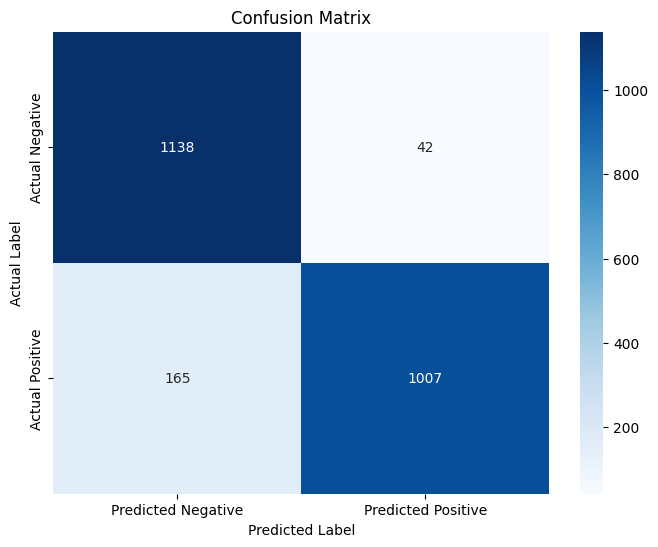

Accuracy: 0.9119897959183674

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      1180
           1       0.96      0.86      0.91      1172

    accuracy                           0.91      2352
   macro avg       0.92      0.91      0.91      2352
weighted avg       0.92      0.91      0.91      2352



In [27]:
# Predict the test set using the ensemble model
y_pred_ensemble = best_rf_classifier.predict(X_test_extended)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

# Print the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
report = classification_report(y_test, y_pred_ensemble)
print("\nClassification Report:\n", report)


# Checking on cross validation

In [28]:
# Initialize the KFold object
kf = KFold(n_splits=8)

# To store accuracy for each fold
accuracies = []

# Iterate over each train-test split
for train_index, test_index in kf.split(X_train):
    # Split data using .iloc for proper indexing
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train and predict with neural network
    model.fit(X_train_fold, y_train_fold)  # Ensure your model is reset or reinitialized here
    nn_train_preds = model.predict(X_train_fold)
    nn_test_preds = model.predict(X_test_fold)

    # Convert NN predictions to binary
    nn_train_preds = (nn_train_preds > 0.5).astype(int)
    nn_test_preds = (nn_test_preds > 0.5).astype(int)

    # Add NN predictions as a new feature
    X_train_fold_extended = np.hstack([X_train_fold, nn_train_preds.reshape(-1, 1)])
    X_test_fold_extended = np.hstack([X_test_fold, nn_test_preds.reshape(-1, 1)])

    # Train the Random Forest on the extended dataset
    best_rf_classifier.fit(X_train_fold_extended, y_train_fold)

    # Predict and evaluate the ensemble model
    y_pred_ensemble = best_rf_classifier.predict(X_test_fold_extended)
    fold_accuracy = accuracy_score(y_test_fold, y_pred_ensemble)
    accuracies.append(fold_accuracy)

# Compute the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print("Average Ensemble Model Accuracy across folds:", average_accuracy)



37/37 [==============================] - 0s 1ms/step
Average Ensemble Model Accuracy across folds: 0.910464701838182
